In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scipy & Stats
from scipy.stats import pearsonr

# Scikit-Learn
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn import feature_selection as fs  # Keeping this if needed separately

# Batch Effect Correction
from combat.pycombat import pycombat

# Dimensionality Reduction
from umap import UMAP

## Batch Correction

In [2]:
%store -r radiomics
%store -r meta_data

# Extracting batch labels required for combat
batch = pd.factorize(meta_data['TMA'].astype(str) + meta_data['Grid'])[0]
batch = pd.Series(batch)

In [3]:
%store -r ICC
%store -r ICC_features

# Define threshold and p-value criteria
threshold = 0.75
p_value_threshold = 0.05

# Determine reliable and unreliable features
reliable_features = [
    feature for feature in ICC_features
    if (ICC[feature]['ICC'][2] > threshold) and (ICC[feature]['pval'][2] < p_value_threshold)
]

unreliable_features = [feature for feature in ICC_features if feature not in reliable_features]

# Output results
num_reliable = len(reliable_features)
num_unreliable = len(unreliable_features)

print(f"Threshold: {threshold}")
print(f"Reliable features: {num_reliable}")
print(f"Unreliable features: {num_unreliable}")

Threshold: 0.75
Reliable features: 242
Unreliable features: 1045


In [4]:
radiomics = radiomics[reliable_features]

# Step 1: Remove zero-variance features (preserving column names)
var_thresh = VarianceThreshold(threshold=0)
radiomics_filtered = pd.DataFrame(var_thresh.fit_transform(radiomics), 
                                  index=radiomics.index, 
                                  columns=radiomics.columns[var_thresh.get_support()])

# Step 2: Apply log transformation (handling negatives properly)
radiomics_log = np.sign(radiomics_filtered) * np.log1p(abs(radiomics_filtered))

# Step 3: Transpose (ComBat expects features as rows, samples as columns)
radiomics_transpose = radiomics_log.T  

# Step 4: Apply pyComBat for batch effect correction
radiomics_transpose_corrected = pycombat(radiomics_transpose, batch)

# Step 5: Transpose back (restoring original structure)
radiomics_corrected = radiomics_transpose_corrected.T  

# Ensure column names are preserved
radiomics_corrected.columns = radiomics_filtered.columns  
radiomics_corrected.index = radiomics.index  # Restore sample index if needed

Found 6 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


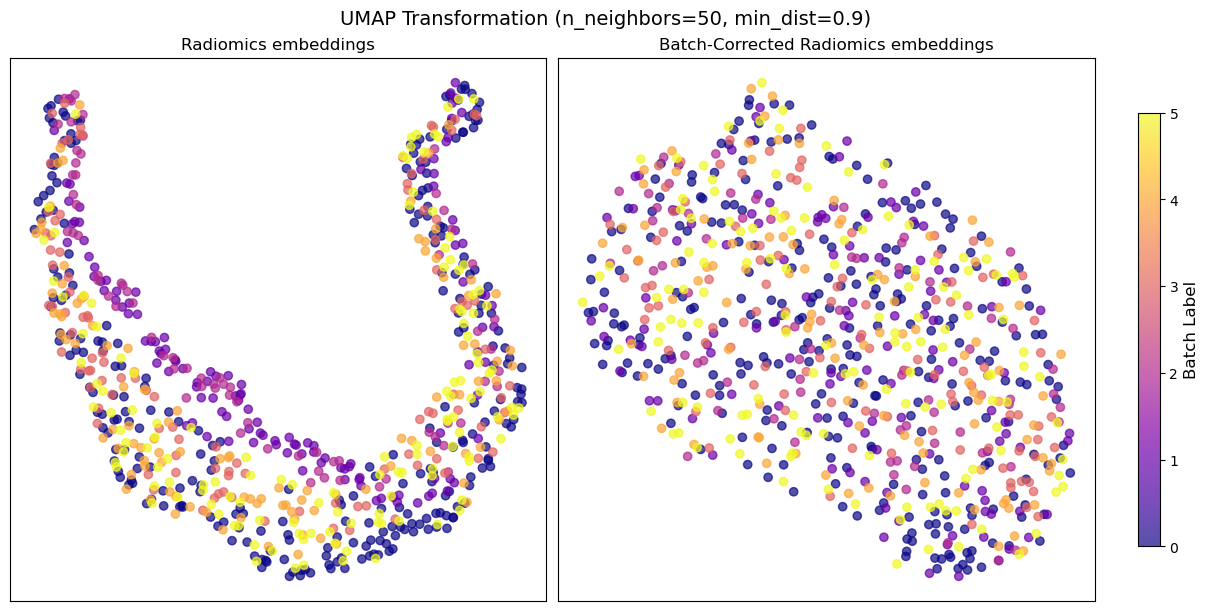

In [5]:
# Define hyperparameters (only one set)
n_neighbors = 50
min_dist = 0.9

# Create a 1x2 figure (two subplots)
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
fig.suptitle(f"UMAP Transformation (n_neighbors={n_neighbors}, min_dist={min_dist})", fontsize=14)

# Apply UMAP on radiomics
reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42, n_jobs=1)
embedding_radiomics = reducer.fit_transform(radiomics)

# First subplot (Radiomics)
scatter1 = axes[0].scatter(embedding_radiomics[:, 0], embedding_radiomics[:, 1], c=batch, cmap='plasma', alpha=0.7)
axes[0].set_title("Radiomics embeddings")
axes[0].set_xticks([])
axes[0].set_yticks([])

# Apply UMAP on radiomics_corrected
embedding_radiomics_corrected = reducer.fit_transform(radiomics_corrected)

# Second subplot (Radiomics Corrected)
scatter2 = axes[1].scatter(embedding_radiomics_corrected[:, 0], embedding_radiomics_corrected[:, 1], c=batch, cmap='plasma', alpha=0.7)
axes[1].set_title("Batch-Corrected Radiomics embeddings")
axes[1].set_xticks([])
axes[1].set_yticks([])

# Create a colorbar
cbar = fig.colorbar(scatter2, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label("Batch Label", fontsize=12)  # Set colorbar title

# Save and display
plt.savefig("umap_projection.png", bbox_inches="tight", dpi=300)
plt.show()


In [6]:
%store radiomics_corrected

Stored 'radiomics_corrected' (DataFrame)
